# Exploratory Data Analysis (EDA)

This notebook performs a very rudimentary EDA on the original CFPB dataset. The objectives of this notebook are to:
1. Introduce the dependent and independent variables that will be used in the modeling approach.
    - The independent variables will be mixed to showcase how this can be modeling using a custom PyTorch Module. The independent variables will consist of: A) unstructured text field and B) some categorical fields.
2. Remove any nulls values from the dataset for future modeling tasks.
    - This preprocessed dataset will be saved back to disk for use in modeling.
3. Save a very reduced dataset which will be used for the debugging feature in pipeline development.
    - This is a trick that can be used to tremendously speed up pipeline/code development.

In [1]:
# Import Libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from torch.utils.data import Dataset, DataLoader

# Allow HF tokenizer parallelism
os.environ['TOKENIZERS_PARALLELISM'] = 'True'

/home/mdunlap/Projects/PyTorch-LLM/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# User Inputs

In [2]:
# Path to Data
PATHS = {'data': '../data/rows.csv',
         'hf_cache': os.environ['TRANSFORMERS_CACHE'],
         'save_processed_data': '../data/cfpb.csv',
         'save_debug_data': '../data/cfpg_debug.csv'}

# Name of the model
model_name = 'bert-base-uncased'

# Load Data and Basic EDA

The basic EDA will be to view the number of unique values, remove nulls, and select a few different source fields that could be used to predicting the target variable.

In [3]:
# Load Data
df = pd.read_csv(PATHS['data'], low_memory=False)

# Display data shape and some rows
print(f'CFPB Data Shape: ({df.shape[0]:,}, {df.shape[1]})')
display(df.head(2))

CFPB Data Shape: (1,282,355, 18)


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,05/10/2019,Checking or savings account,Checking account,Managing an account,Problem using a debit or ATM card,NaN,NaN,NAVY FEDERAL CREDIT UNION,FL,328XX,Older American,NaN,Web,05/10/2019,In progress,Yes,NaN,3238275
1,05/10/2019,Checking or savings account,Other banking product or service,Managing an account,Deposits and withdrawals,NaN,NaN,BOEING EMPLOYEES CREDIT UNION,WA,98204,NaN,NaN,Referral,05/10/2019,Closed with explanation,Yes,NaN,3238228


In [4]:
# Uniques for each field
tmp = df.describe(include='all').loc['unique', :]
display(tmp.to_frame().style.format("{:,.0f}"))
del tmp

,unique
Date received,"2,717"
Product,18
Sub-product,76
Issue,167
Sub-issue,218
Consumer complaint narrative,"366,945"
Company public response,10
Company,"5,275"
State,63
ZIP code,"22,591"


In [5]:
# Number of nulls in source fields
source_fields = ['Consumer complaint narrative',
                 'State',
                 'Company response to consumer']
target = 'Product'
print(f'Number of Non-Nulls in Each Column BEFORE Removing Nulls')
n_rows = len(df)
for col in source_fields:
    print(f'\t{col}: {n_rows - df[col].isnull().sum():,}')

# Reduce the dataframe to only non-null consumer complaints
data = (df.dropna(subset=source_fields)
        .reset_index(drop=True))
print((f'CFPB Data Shape After Removing Nulls:'
       f'({data.shape[0]:,}, {data.shape[1]})'))

# Number of nulls in source fields AFTER removing Nulls
print(f'Number of Non-Nulls in Each Column AFTER Removing Nulls')
n_rows = len(data)
for col in source_fields:
    print(f'\t{col}: {n_rows - data[col].isnull().sum():,}')

Number of Non-Nulls in Each Column BEFORE Removing Nulls
	Consumer complaint narrative: 383,564
	State: 1,262,955
	Company response to consumer: 1,282,348
CFPB Data Shape After Removing Nulls:(382,174, 18)
Number of Non-Nulls in Each Column AFTER Removing Nulls
	Consumer complaint narrative: 382,174
	State: 382,174
	Company response to consumer: 382,174


In [6]:
# Value counts for each categorical source field and target
for col in source_fields[1:] + [target]:
    print(col)
    tmp = df[col].value_counts().to_frame().style.format("{:,.0f}")
    display(tmp)
    del tmp

State


,count
State,
CA,"176,009"
FL,"126,487"
TX,"107,585"
NY,"86,143"
GA,"67,102"
IL,"49,599"
NJ,"47,799"
PA,"44,131"
NC,"39,580"


Company response to consumer


,count
Company response to consumer,
Closed with explanation,"993,221"
Closed with non-monetary relief,"158,716"
Closed with monetary relief,"74,243"
Closed without relief,"17,868"
Closed,"17,611"
In progress,"9,277"
Untimely response,"6,108"
Closed with relief,"5,304"


Product


,count
Product,
Mortgage,"278,098"
Debt collection,"244,873"
"Credit reporting, credit repair services, or other personal consumer reports","225,978"
Credit reporting,"140,432"
Credit card,"89,190"
Bank account or service,"86,206"
Student loan,"51,685"
Credit card or prepaid card,"47,653"
Checking or savings account,"40,641"


# Number of Tokens Distribution

The field `Consumer complaint narrative` is the unstructured text source field that will be used to predict the target variable. The `bert-base-uncased` model used in this example only allows for a maximum of 512 tokens. Text past this point will be truncated. There are other methods (e.g., sliding windows) that can handle longer text but will not be implemented in this repository. Therefore, we can check the distribution of the number tokens for this field. 

In [7]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(f'{PATHS["hf_cache"]}/'
                                          f'{model_name}')

# View the Model configuration JSON
os.system(f'cat {PATHS["hf_cache"]}/{model_name}/config.json')

{
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.6.0.dev0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}


0

Notice the 512 in the `max_position_embeddings` parameter for the BERT model. BERT can only take input sequences up to 512 tokens in length. There are solutions for handling longer text as discussed in this article by [Salt Data Labs](https://www.saltdatalabs.com/blog/bert-how-to-handle-long-documents#:~:text=However%2C%20BERT%20can%20only%20take,much%20longer%20than%20512%20words.).

To speedup the calculations the Torch Dataset and DataLoader modules will be used which allows for multi-core processing using parameter `num_workers`. This provides over a 8X speed up on my computer versus using a simple pandas.apply() function call (i.e., single core use).

Number of token distribution:


count    382174.000000
mean        248.869156
std         269.982546
min           3.000000
25%          91.000000
50%         172.000000
75%         314.000000
max        9498.000000
Name: num_tokens, dtype: float64

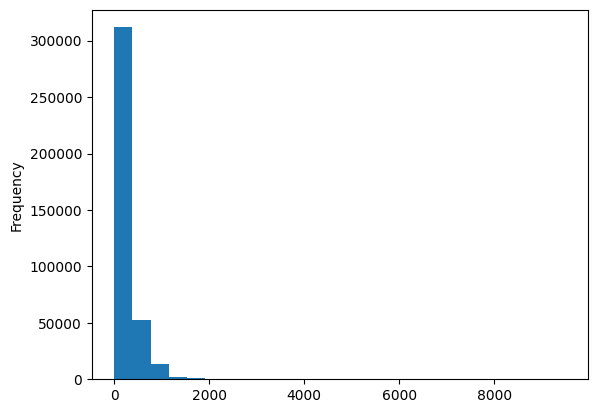

In [8]:
class CountTokens(Dataset):
    def __init__(self, texts, tok):
        self.texts = texts
        self.tok = tok
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, item):
        # Number of tokens in string
        values = self.tok.encode_plus(text=self.texts[item],
                                      padding=False,
                                      truncation=False)
        return len(values['input_ids'])

# Temporary Dataframe
tmp = data[source_fields[0]].copy().to_frame()

# Datasets and dataloaders
tokens_dataset = CountTokens(texts=tmp[source_fields[0]].values,
                             tok=tokenizer)
tokens_dataloader = DataLoader(tokens_dataset,
                               batch_size=1_024,
                               shuffle=False,
                               num_workers=8)

# Count number of tokens in dataframe
num_tokens = []
for count, token_lengths in enumerate(tokens_dataloader):
    num_tokens.extend(token_lengths.numpy().tolist())
tmp['num_tokens'] = num_tokens
print('Number of token distribution:')
display(tmp.num_tokens.describe())
tmp.num_tokens.plot(kind='hist', bins=25)
plt.show()
del tmp

# Save Data to Disk

The preprocessed data being saved below will be used for modeling.

In [9]:
# Save preprocessed data
data.to_csv(PATHS['save_processed_data'], index=False)

In [10]:
# Downsample data to a much smaller size
# This data will be quicker for all operations when debugging code
prod_uniques = data.Product.unique()

# Sample 5 instances for each value in Product
# Product has 18 unique values; therefore 18 * 5 = 90 instances
data_debug = None
for prod_value in prod_uniques:
    tmp = data[data.Product == prod_value].iloc[0:5, :]
    if data_debug is None:
        data_debug = tmp
    else:
        data_debug = pd.concat([data_debug, tmp],
                               ignore_index=True)
# Shuffle the rows
data_debug = data_debug.sample(frac=1)
print(f'Num. of Instances in Debug Data: {len(data_debug):,}')

data_debug.to_csv(PATHS['save_debug_data'], index=False)

Num. of Instances in Debug Data: 90


# Summary

- **DATA**:
    - Number of Independent variables = 3
        - `Consumer complaint narrative`: string of unstructured text and all instances are unique 
        - `State`: categorical with 62 unique values
        - `Company response to consumer`: categorical with 8 unique values
    - Dependent Variable = `Product`
        - `Product`: categorical with 18 unique values
    - Two datasets were created for modeling:
        - `Primary` dataset has ~386K instances
        - `Debug` dataset with 90 instances
- **NOTES**: 
    - No emphasis was placed on selecting optimal independent variables for modeling and were deemed relevant for the purpose of this repository which is to highlight a workflow. Mixed data types (i.e., text and categorical variables) were selected to demonstrate their usage during modeling.
